<a href="https://colab.research.google.com/github/vitroid/GenIce/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tests to run GenIce on Jupyter and Google Colaboratory.

In [ ]:
# install GenIce2 and extra plugins from PyPI via pip.
! pip install genice2 genice2-svg genice2-cage genice2-twist

# Instead, install them from github repository.
# ! pip install git+https://github.com/vitroid/GenIce.git

# extra plugin to show the structure in SVG.
# ! pip install git+https://github.com/vitroid/genice-svg.git

# extra plugin to detect cages.
# ! pip install git+https://github.com/vitroid/genice-cage.git

print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
exit()

A simplest example.

In [6]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "ice11").Lattice() 
formatter  = safe_import("format", "gromacs").Format()
water      = safe_import("molecule", "spce").Molecule()
ice = GenIce(lattice).generate_ice(water, formatter)
print(ice)

Generated by GenIce https://github.com/vitroid/GenIce 
48
    1SOL     Ow    1   0.220  -0.003   0.095
    1SOL     Hw    2   0.302  -0.050   0.062
    1SOL     Hw    3   0.220   0.092   0.062
    2SOL     Ow    4   0.220   0.256   0.004
    2SOL     Hw    5   0.302   0.304   0.037
    2SOL     Hw    6   0.220   0.256  -0.096
    3SOL     Ow    7   0.229   0.003   0.370
    3SOL     Hw    8   0.229   0.003   0.270
    3SOL     Hw    9   0.148  -0.045   0.404
    4SOL     Ow   10   0.229   0.262   0.462
    4SOL     Hw   11   0.148   0.309   0.429
    4SOL     Hw   12   0.229   0.167   0.429
    5SOL     Ow   13   0.669  -0.003   0.095
    5SOL     Hw   14   0.751  -0.050   0.062
    5SOL     Hw   15   0.669   0.092   0.062
    6SOL     Ow   16   0.669   0.256   0.004
    6SOL     Hw   17   0.669   0.256  -0.096
    6SOL     Hw   18   0.751   0.304   0.037
    7SOL     Ow   19   0.678   0.003   0.370
    7SOL     Hw   20   0.678   0.003   0.270
    7SOL     Hw   21   0.597  -0.045   0.4

Using the Forms syntax of Google Colab.

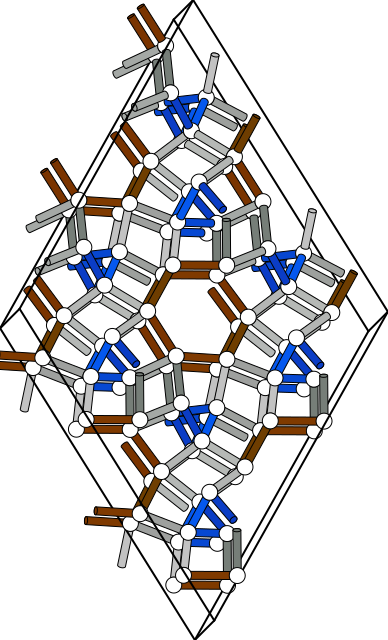

In [5]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

ice = "engel12" #@param ["ice1h", "ice2", "ice3", "engel12"] {allow-input: true}
#@markdown Press *Shift+Enter* to execute.

lattice    = safe_import("lattice", ice).Lattice() 
# formatter  = safe_import("format", "svg").Format(shadow=True,rotatex=5,rotatey=5)
formatter  = safe_import("format", "twist").Format(svg=True,rotatex=5,rotatey=5)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

from IPython.display import SVG, display
display(SVG(img))

PNG renderer is also included in genice_svg package.

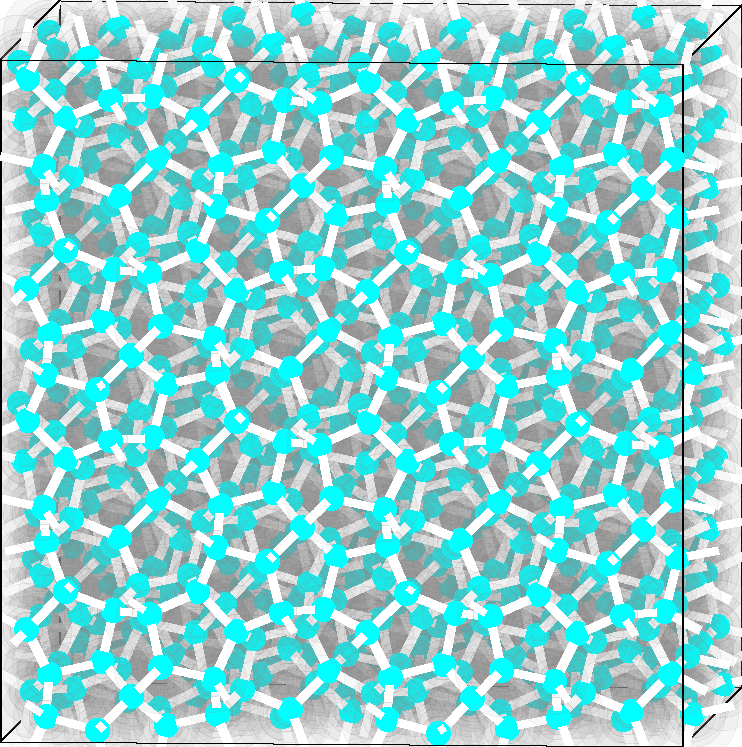

In [8]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "CS2").Lattice() 
formatter  = safe_import("format", "png").Format(shadow="#8881",encode=False,bg="#fff",rotatex=5,rotatey=5)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

from IPython.display import display
display(img)

Or save it in a PNG file.

In [ ]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "ice3").Lattice() 
formatter  = safe_import("format", "png").Format(shadow="#8881",encode=True,bg="#fff",rotatex=5,rotatey=5)
water      = safe_import("molecule", "spce").Molecule()
img = GenIce(lattice, rep=[2,2,2]).generate_ice(water, formatter)

with open("ice3.png", "wb") as f:
    f.write(img)

Some statistical analyses are also available.

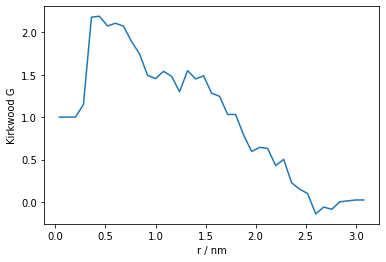

In [ ]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "T").Lattice() 
formatter  = safe_import("format", "_KG").Format()
water      = safe_import("molecule", "spce").Molecule()
result = GenIce(lattice).generate_ice(water, formatter)

import numpy as np
from matplotlib import pyplot as plt

kg = np.fromstring(result, dtype=float, sep=" ")
N = kg.shape[0]
kg = kg.reshape([N//2, 2])
plt.plot(kg[:,0], kg[:,1])
plt.xlabel("r / nm")
plt.ylabel("Kirkwood G")
plt.show()

You may want to see the process log.

In [10]:
from logging import getLogger, INFO, DEBUG, WARNING
logger = getLogger()
logger.setLevel(INFO)

from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice   = safe_import("lattice", "1c").Lattice() 
formatter = safe_import("format", "gromacs").Format()
water     = safe_import("molecule", "spce").Molecule()
ice = GenIce(lattice, rep=(16,16,16), signature="Jupyter test").generate_ice(water, formatter)
with open("ice1c.gro", "w") as f:
    f.write(ice)

logger.setLevel(WARNING)

INFO:root:__init__: Constructor of GenIce.
INFO:root:  
INFO:root:  Jupyter test
INFO:root:No rotmatrices in lattice
INFO:root:Cell dimension:
INFO:root:  a = 4.0
INFO:root:  b = 4.0
INFO:root:  c = 4.0
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:Bond length (specified): 1.9
INFO:root:Target Density: 0.92
INFO:root:Original Density: 0.0037363002324809044
INFO:root:Bond length (scaled, nm): 0.3031365108343017
INFO:root:__init__: end.
INFO:root:__init__: 25 ms
INFO:root:Stage1: Replicate water molecules to make a repeated cell.
INFO:root:  Number of water molecules: 32768
INFO:root:  Number of water nodes: 8
INFO:root:Cell dimension:
INFO:root:  a = 0.6381821280722142
INFO:root:  b = 0.6381821280722142
INFO:root:  c = 0.6381821280722142
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:Stage1: end.
INFO:root:Stage1: 18 ms
INFO:root:Stage2: Make a random graph and replicate.
INFO:root:Stage2: end.
INFO:root:Stage2: 954 ms
INFO:root:  Num

You can access the "raw" (internal) data.

In [8]:
from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "xFAU").Lattice(rep=3) 
formatter  = safe_import("format", "raw").Format(stage=(1,))
water      = safe_import("molecule", "spce").Molecule()
raw = GenIce(lattice, signature="Aeroice 3xFAU").generate_ice(water, formatter)

raw

INFO:root:Cell dimension:
INFO:root:  a = 4.0
INFO:root:  b = 4.0
INFO:root:  c = 4.0
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:HB connectivity is not defined.
DEBUG:root:  Estimating the bond threshold length...
DEBUG:root:cell a [4. 0. 0.]
DEBUG:root:cell b [0. 4. 0.]
DEBUG:root:cell c [0. 0. 4.]
DEBUG:root:Grid divisions: [4. 4. 4.]
INFO:root:Bond length (estim.): 0.34962096971536
INFO:root:Density is not specified. Assume the density from lattice.
INFO:root:Closest pair distance: 0.31783724519578177 (should be around 0.276 nm)
INFO:root:Target Density: 0.2738861818861952
INFO:root:Original Density: 0.17934241115908342
INFO:root:Bond length (scaled, nm): 0.3036000000000001
INFO:root:Orientations of some edges are fixed.
INFO:root:__init__: end.
INFO:root:__init__: 639 ms
INFO:root:Stage1: Replicate water molecules to make a repeated cell.
INFO:root:  Number of water molecules: 384
INFO:root:  Pairs are not given explicitly.
INFO:root:  Estimating the b

{'cagetypes': None,
 'repcagepos': None,
 'repcagetype': None,
 'repcell': array([[3.47347586, 0.        , 0.        ],
        [0.        , 3.47347586, 0.        ],
        [0.        , 0.        , 3.47347586]]),
 'reppositions': array([[1.38777878e-17, 1.12372436e-01, 5.61862178e-02],
        [1.38777878e-17, 5.61862178e-02, 1.12372436e-01],
        [5.61862178e-02, 1.38777878e-17, 1.12372436e-01],
        ...,
        [1.37627564e-01, 6.93813782e-01, 7.50000000e-01],
        [1.93813782e-01, 6.37627564e-01, 7.50000000e-01],
        [2.50000000e-01, 6.37627564e-01, 6.93813782e-01]])}

Use the raw data to plot by yourself.

In [9]:
waters = raw["reppositions"]
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x = waters[:,0], 
                                   y = waters[:,1], 
                                   z = waters[:,2],
                                   marker=dict(size=10),
                                   mode = 'markers'
                                   )])
fig.show()

# Under development

Using meshcat-python.

In [9]:
# ! git clone https://github.com/vitroid/genice-meshcat.git
# ! cd genice-meshcat; make install
! pip uninstall -y meshcat-python genice2-meshcat
! \rm -rf meshcat-python genice2-meshcat
! git clone -b colab https://github.com/russTedrake/meshcat-python.git
! cd meshcat-python; python setup.py install
! git clone -b colab https://github.com/vitroid/genice2-meshcat.git
! cd meshcat-python; python setup.py install

print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
exit()


Cloning into 'meshcat-python'...
remote: Enumerating objects: 938, done.
remote: Total 938 (delta 0), reused 0 (delta 0), pack-reused 938
Receiving objects: 100% (938/938), 177.75 KiB | 957.00 KiB/s, done.
Resolving deltas: 100% (541/541), done.
running install
running bdist_egg
running egg_info
creating src/meshcat.egg-info
writing src/meshcat.egg-info/PKG-INFO
writing dependency_links to src/meshcat.egg-info/dependency_links.txt
writing entry points to src/meshcat.egg-info/entry_points.txt
writing requirements to src/meshcat.egg-info/requires.txt
writing top-level names to src/meshcat.egg-info/top_level.txt
writing manifest file 'src/meshcat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'src/meshcat/viewer/node_modules'
writing manifest file 'src/meshcat.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib

In [4]:
%tb
from logging import getLogger, INFO, DEBUG, WARNING
logger = getLogger()
logger.setLevel(DEBUG)

from genice2.genice import GenIce
from genice2.plugin import safe_import

lattice    = safe_import("lattice", "CS1").Lattice() 
formatter  = safe_import("format", "meshcat").Format(Jupyter=True)
water      = safe_import("molecule", "spce").Molecule()
guests = {"12": {"me":1.0},   # Fill 100% of 12-hedral cages with methanes.
               "14": {"thf": 0.5, "H2": 0.5}}  # Fill 50% of 14-hedral cages with THFs and 50% with hydrogens.
GenIce(lattice, rep=(2,2,2)).generate_ice(water, formatter, guests=guests)


SystemExit: ignored

Nonexistent module: meshcat


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
!genice2 CS1 -f meshcat --debug



2021-01-27 08:35:31,207 DEBUG Debug mode.
2021-01-27 08:35:31,207 DEBUG Lattice: CS1
2021-01-27 08:35:31,207 DEBUG Load module: genice2.lattices.CS1
2021-01-27 08:35:31,208 INFO __init__: Constructor of GenIce.
2021-01-27 08:35:31,208 INFO   
2021-01-27 08:35:31,208 INFO   Command line: /usr/local/bin/genice2 CS1 -f meshcat --debug
2021-01-27 08:35:31,208 INFO No rotmatrices in lattice
2021-01-27 08:35:31,208 DEBUG Waters: 138
2021-01-27 08:35:31,208 DEBUG ('MAT:', array([[12.23881832,  0.        ,  0.        ],
       [ 0.        , 12.23881832,  0.        ],
       [ 0.        ,  0.        , 12.23881832]]))
2021-01-27 08:35:31,209 INFO Cell dimension:
2021-01-27 08:35:31,209 INFO   a = 12.238818320447
2021-01-27 08:35:31,209 INFO   b = 12.238818320447
2021-01-27 08:35:31,209 INFO   c = 12.238818320447
2021-01-27 08:35:31,209 INFO   A = 90.0
2021-01-27 08:35:31,209 INFO   B = 90.0
2021-01-27 08:35:31,209 INFO   C = 90.0
2021-01-27 08:35:31,210 INFO HB connectivity is not defined.
2021-

In [6]:
! cd genice-meshcat; python genice2_meshcat/formats/meshcat.py

Traceback (most recent call last):
  File "genice2_meshcat/formats/meshcat.py", line 16, in <module>
    import meshcat
  File "/content/genice-meshcat/genice2_meshcat/formats/meshcat.py", line 17, in <module>
    from meshcat.jupyter import JupyterVisualizer
ModuleNotFoundError: No module named 'meshcat.jupyter'; 'meshcat' is not a package
